# Q3) Where will I spend the best time? What are the most important features that affect the final rating?

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
from jupyterthemes import jtplot
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

ROOT_DIR = '..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

SEATTLE_LISTINGS_COLS = os.path.join(
    DATA_INTERIM, 'seattle', 'listings_cols_df.pkl')

import sys
sys.path.append(SRC_DIR)
sys.path.append(os.path.join(SRC_DIR, 'data'))

import preprocessing as pp
import missing_data as md
import make_dataset

In [47]:
# If the dataset is already processed comment the line below
# make_dataset.create_dataset()
calendar, listings, reviews = make_dataset.load_processed()
listings_cols_df = pd.read_pickle(SEATTLE_LISTINGS_COLS)

In [3]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,calculated_host_listings_count,reviews_per_month,review_scores_rating_missing,review_scores_accuracy_missing,review_scores_cleanliness_missing,review_scores_checkin_missing,review_scores_communication_missing,review_scores_location_missing,review_scores_value_missing,reviews_per_month_missing
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,,...,2,4.070000,0,0,0,0,0,0,0,0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,6,1.480000,0,0,0,0,0,0,0,0
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,2,1.150000,0,0,0,0,0,0,0,0
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,,A charming apartment that sits atop Queen Anne...,none,,...,1,2.078919,1,1,1,1,1,1,1,1
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,1,0.890000,0,0,0,0,0,0,0,0


Let's drop the columns that have no relevant information (those like urls or internal technical information, and also those that have only one value or are duplicates). I will also throw the "free text" columns, as I won't take the time to process them.

In [5]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [7]:
listings.last_scraped.unique()

array(['2016-01-04T00:00:00.000000000'], dtype='datetime64[ns]')

In [13]:
listings.experiences_offered.unique()

array(['none'], dtype=object)

In [27]:
interesting_cols = listings.columns.tolist()
num_values = listings.apply(lambda x: x.unique().shape[0])
unicols = listings.columns[num_values == 1].tolist()
all_diff_cols = listings.columns[num_values == listings.shape[0]].tolist()

In [31]:
num_values.sort_values(ascending=False).head()

id             3816
picture_url    3816
longitude      3816
latitude       3816
listing_url    3816
dtype: int64

In [32]:
unicols

['scrape_id',
 'last_scraped',
 'experiences_offered',
 'market',
 'country_code',
 'country',
 'has_availability',
 'calendar_last_scraped',
 'requires_license',
 'jurisdiction_names']

Let's remove the columns that have only one value

In [40]:
def remove_cols(x, minus):
    return list(set(x) - set(minus))

In [41]:
interesting_cols = remove_cols(interesting_cols, unicols)

In [38]:
import re

url_cols = [re.match('.*_url', c).group(0) for c in interesting_cols
            if re.match('.*_url', c) is not None]
url_cols

['medium_url',
 'xl_picture_url',
 'host_url',
 'listing_url',
 'thumbnail_url',
 'host_thumbnail_url',
 'picture_url',
 'host_picture_url']

In [42]:
interesting_cols = remove_cols(interesting_cols, url_cols)

In [43]:
all_diff_cols

['id', 'listing_url', 'picture_url', 'latitude', 'longitude']

In [45]:
len(interesting_cols)

80

In [51]:
free_text_cols = pp.get_column_by_kind(listings_cols_df, 'free_text_cols')
free_text_cols

['name',
 'summary',
 'space',
 'description',
 'neighborhood_overview',
 'notes',
 'transit',
 'host_about',
 'host_name']

In [52]:
interesting_cols = remove_cols(interesting_cols, free_text_cols)

In [53]:
interesting_cols

['neighbourhood_cleansed',
 'review_scores_cleanliness_missing',
 'number_of_reviews',
 'id',
 'is_location_exact',
 'neighbourhood_group_cleansed',
 'review_scores_rating_missing',
 'bed_type',
 'review_scores_accuracy',
 'cancellation_policy',
 'reviews_per_month',
 'city',
 'host_location',
 'host_identity_verified',
 'accommodates',
 'price',
 'host_verifications',
 'guests_included',
 'first_review',
 'host_neighbourhood',
 'extra_people',
 'review_scores_communication',
 'bathrooms',
 'cleaning_fee',
 'calculated_host_listings_count',
 'host_has_profile_pic',
 'host_id',
 'security_deposit',
 'host_response_rate',
 'host_is_superhost',
 'minimum_nights',
 'latitude',
 'longitude',
 'calendar_updated',
 'street',
 'review_scores_value_missing',
 'review_scores_checkin',
 'availability_90',
 'review_scores_location_missing',
 'require_guest_profile_picture',
 'review_scores_accuracy_missing',
 'availability_30',
 'bedrooms',
 'weekly_price',
 'review_scores_location',
 'host_respon

In [158]:
data = listings[interesting_cols]
print(data.shape)
data.head()

(3816, 71)


,neighbourhood_cleansed,review_scores_cleanliness_missing,number_of_reviews,id,is_location_exact,neighbourhood_group_cleansed,review_scores_rating_missing,bed_type,review_scores_accuracy,cancellation_policy,...,review_scores_rating,room_type,host_since,instant_bookable,property_type,host_total_listings_count,state,host_acceptance_rate,last_review,amenities
0,West Queen Anne,0,207,241032,True,Queen Anne,0,Real Bed,10.000000,moderate,...,95.000000,Entire home/apt,2011-08-11,False,Apartment,3.0,WA,100.000000,2016-01-02,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,West Queen Anne,0,43,953595,True,Queen Anne,0,Real Bed,10.000000,strict,...,96.000000,Entire home/apt,2013-02-21,False,Apartment,6.0,WA,100.000000,2015-12-29,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,West Queen Anne,0,20,3308979,True,Queen Anne,0,Real Bed,10.000000,strict,...,97.000000,Entire home/apt,2014-06-12,False,House,2.0,WA,100.000000,2015-09-03,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3,West Queen Anne,1,0,7421966,True,Queen Anne,1,Real Bed,9.636392,flexible,...,94.539262,Entire home/apt,2013-11-06,False,Apartment,1.0,WA,99.967159,2016-01-04,"{Internet,""Wireless Internet"",Kitchen,""Indoor ..."
4,West Queen Anne,0,38,278830,True,Queen Anne,0,Real Bed,9.000000,strict,...,92.000000,Entire home/apt,2011-11-29,False,House,2.0,WA,99.967159,2015-10-24,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."


Let's transform the columns that have lists of things

In [159]:
data.amenities[0]

'{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}'

In [160]:
data.host_verifications[0]

"['email', 'phone', 'reviews', 'kba']"

In [161]:
def str_to_list(text):
    return text[1:-1].split(',')

In [162]:
def extract_list_items(series):
    items = set()
    for record in series:
        items = items | set(str_to_list(record))
    items = list(items)
    items.remove('')
    return items

In [163]:
def str_to_ohe(text, col_series):
    present = str_to_list(text)
    return col_series.isin(present).astype(int).values

In [164]:
def series_to_ohe(series):
    columns = extract_list_items(series)
    ohe_data = np.vstack(series.apply(str_to_ohe, 
                                      col_series=pd.Series(columns)))
    return pd.DataFrame(ohe_data, index=series.index, columns=columns)

In [221]:
series_to_ohe(data.amenities).head()

,Washer,Breakfast,Internet,Iron,Pool,"""Laptop Friendly Workspace""","""Hair Dryer""",Hangers,"""Elevator in Building""",Heating,...,"""Wireless Internet""","""Smoking Allowed""","""Suitable for Events""","""First Aid Kit""","""Lock on Bedroom Door""",TV,"""Pets live on this property""","""Hot Tub""","""Smoke Detector""","""Fire Extinguisher"""
0,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,1,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,1,0,0,1,1
2,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,1,1,1,0
3,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,1
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,1,0,0,1,1


In [222]:
series_to_ohe(data.host_verifications).head()

,'manual_online','reviews','facebook','reviews','manual_offline','google','photographer','email','phone','sent_id','google','jumio','weibo','linkedin','amex','kba','phone'
0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0
1,0,0,1,1,0,0,0,1,1,0,0,1,0,1,0,0,0
2,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0
3,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0
4,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0


And let's divide the data into numeric and non-numeric

In [223]:
data.shape

(3816, 71)

In [224]:
numeric = data.select_dtypes(['int', 'float'])
print(numeric.shape)
numeric.head()

(3816, 43)


,review_scores_cleanliness_missing,number_of_reviews,id,review_scores_rating_missing,review_scores_accuracy,reviews_per_month,accommodates,price,guests_included,extra_people,...,maximum_nights,availability_365,monthly_price,beds,review_scores_checkin_missing,review_scores_communication_missing,review_scores_value,review_scores_rating,host_total_listings_count,host_acceptance_rate
0,0,207,241032,0,10.000000,4.070000,4,85.0,2,5.0,...,365,346,1887.055014,1.0,0,0,10.000000,95.000000,3.0,100.000000
1,0,43,953595,0,10.000000,1.480000,4,150.0,1,0.0,...,90,291,3000.000000,1.0,0,0,10.000000,96.000000,6.0,100.000000
2,0,20,3308979,0,10.000000,1.150000,11,975.0,10,25.0,...,30,220,21645.631046,7.0,0,0,10.000000,97.000000,2.0,100.000000
3,1,0,7421966,1,9.636392,2.078919,3,100.0,1,0.0,...,1125,143,2300.000000,2.0,1,1,9.452245,94.539262,1.0,99.967159
4,0,38,278830,0,9.000000,0.890000,6,450.0,6,15.0,...,1125,365,9990.291252,3.0,0,0,9.000000,92.000000,2.0,99.967159


In [225]:
tf_cols = pp.get_column_by_kind(listings_cols_df, 'tf_cols')
tf_cols.remove('has_availability')
tf_cols.remove('requires_license')

In [226]:
bool_feats = data[tf_cols]
print(bool_feats.shape)
bool_feats.head()

(3816, 7)


,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,False,True,True,True,False,False,False
1,True,True,True,True,False,True,True
2,False,True,True,True,False,False,False
3,False,True,True,True,False,False,False
4,False,True,True,True,False,False,False


In [227]:
numeric = numeric.join(bool_feats.astype('int'))
numeric.shape

(3816, 50)

In [228]:
remaining = data.drop(numeric.columns, axis=1)
print(remaining.shape)

(3816, 21)


In [229]:
amenities_ohe = series_to_ohe(data.amenities)
host_verifications = series_to_ohe(data.host_verifications)
remaining = remaining.drop(['amenities', 'host_verifications'], axis=1)

In [230]:
print(remaining.shape)
remaining.head()

(3816, 19)


,neighbourhood_cleansed,neighbourhood_group_cleansed,bed_type,cancellation_policy,city,host_location,first_review,host_neighbourhood,calendar_updated,street,host_response_time,zipcode,smart_location,neighbourhood,room_type,host_since,property_type,state,last_review
0,West Queen Anne,Queen Anne,Real Bed,moderate,Seattle,"Seattle, Washington, United States",2011-11-01,Queen Anne,4 weeks ago,"Gilman Dr W, Seattle, WA 98119, United States",within a few hours,98119,"Seattle, WA",Queen Anne,Entire home/apt,2011-08-11,Apartment,WA,2016-01-02
1,West Queen Anne,Queen Anne,Real Bed,strict,Seattle,"Seattle, Washington, United States",2013-08-19,Queen Anne,today,"7th Avenue West, Seattle, WA 98119, United States",within an hour,98119,"Seattle, WA",Queen Anne,Entire home/apt,2013-02-21,Apartment,WA,2015-12-29
2,West Queen Anne,Queen Anne,Real Bed,strict,Seattle,"Seattle, Washington, United States",2014-07-30,Queen Anne,5 weeks ago,"West Lee Street, Seattle, WA 98119, United States",within a few hours,98119,"Seattle, WA",Queen Anne,Entire home/apt,2014-06-12,House,WA,2015-09-03
3,West Queen Anne,Queen Anne,Real Bed,flexible,Seattle,"Seattle, Washington, United States",2016-01-04,Queen Anne,6 months ago,"8th Avenue West, Seattle, WA 98119, United States",no data,98119,"Seattle, WA",Queen Anne,Entire home/apt,2013-11-06,Apartment,WA,2016-01-04
4,West Queen Anne,Queen Anne,Real Bed,strict,Seattle,"Seattle, Washington, United States",2012-07-10,Queen Anne,7 weeks ago,"14th Ave W, Seattle, WA 98119, United States",within an hour,98119,"Seattle, WA",Queen Anne,Entire home/apt,2011-11-29,House,WA,2015-10-24


In [231]:
date_cols = pp.get_column_by_kind(listings_cols_df, 'date_cols')
date_cols.remove('last_scraped')
date_cols.remove('calendar_last_scraped')
dates = remaining[date_cols]
dates.head()

,host_since,first_review,last_review
0,2011-08-11,2011-11-01,2016-01-02
1,2013-02-21,2013-08-19,2015-12-29
2,2014-06-12,2014-07-30,2015-09-03
3,2013-11-06,2016-01-04,2016-01-04
4,2011-11-29,2012-07-10,2015-10-24


In [232]:
dates = dates.apply(lambda x: x.apply(lambda x: x.timestamp()))
dates = dates - dates.min().min()
dates.head()

,host_since,first_review,last_review
0,86745600.0,93830400.0,225417600.0
1,135129600.0,150595200.0,225072000.0
2,176256000.0,180403200.0,214963200.0
3,157420800.0,225590400.0,225590400.0
4,96249600.0,115603200.0,219369600.0


In [233]:
remaining = remaining.drop(dates.columns, axis=1)
print(remaining.shape)
remaining.head(2)

(3816, 16)


,neighbourhood_cleansed,neighbourhood_group_cleansed,bed_type,cancellation_policy,city,host_location,host_neighbourhood,calendar_updated,street,host_response_time,zipcode,smart_location,neighbourhood,room_type,property_type,state
0,West Queen Anne,Queen Anne,Real Bed,moderate,Seattle,"Seattle, Washington, United States",Queen Anne,4 weeks ago,"Gilman Dr W, Seattle, WA 98119, United States",within a few hours,98119,"Seattle, WA",Queen Anne,Entire home/apt,Apartment,WA
1,West Queen Anne,Queen Anne,Real Bed,strict,Seattle,"Seattle, Washington, United States",Queen Anne,today,"7th Avenue West, Seattle, WA 98119, United States",within an hour,98119,"Seattle, WA",Queen Anne,Entire home/apt,Apartment,WA


Let's drop the street feature, and look at the host_location

In [239]:
remaining.host_location.value_counts()

Seattle, Washington, United States                             3265
US                                                              246
Spokane, Washington, United States                               41
Kent, Washington, United States                                  34
Los Angeles, California, United States                           13
Bellevue, Washington, United States                              12
San Francisco, California, United States                         11
Mercer Island, Washington, United States                         10
Kirkland, Washington, United States                               8
New York, New York, United States                                 6
Seattle                                                           5
Sammamish, Washington, United States                              5
Shoreline, Washington, United States                              5
Vashon, Washington, United States                                 5
Seattle, Washington                             

Too many locations, I think the feature would be "Seattle or not Seattle"

In [241]:
().mean()

0.8556079664570231

In [245]:
host_location = (remaining.host_location == \
                 'Seattle, Washington, United States').astype(int)
host_location.head()

0    1
1    1
2    1
3    1
4    1
Name: host_location, dtype: int64

In [247]:
remaining = remaining.drop(['host_location', 'street'], axis=1)
remaining.shape

(3816, 14)

In [250]:
remaining.describe()

,neighbourhood_cleansed,neighbourhood_group_cleansed,bed_type,cancellation_policy,city,host_neighbourhood,calendar_updated,host_response_time,zipcode,smart_location,neighbourhood,room_type,property_type,state
count,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816,3816
unique,87,17,5,3,7,117,34,5,28,7,96,3,16,2
top,Broadway,Other neighborhoods,Real Bed,strict,Seattle,Capitol Hill,today,within an hour,98122,"Seattle, WA",Capitol Hill,Entire home/apt,House,WA
freq,397,794,3655,1417,3808,405,706,1692,421,3808,351,2539,1734,3815


So, all the features seem to be reasonable for one hot encoding, except the neighbourhood ones. Those have too many unique values (would create too many features). In any case, I will use a decision tree based method, so the One-hot-encoding won't be necessary.

Let's join all the features.

In [252]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

In [255]:
def decode(df, encoders):
    return df.apply(lambda x: encoders[x.name].inverse_transform(x))

def encode(df, encoders, fit=False):
    if fit:
        return df.apply(lambda x: encoders[x.name].fit_transform(x))
    else:
        return df.apply(lambda x: encoders[x.name].transform(x))

In [256]:
encoders = defaultdict(LabelEncoder)
cat_enc = encode(remaining, encoders, fit=True)
print(cat_enc.shape)
cat_enc.head()

(3816, 14)


,neighbourhood_cleansed,neighbourhood_group_cleansed,bed_type,cancellation_policy,city,host_neighbourhood,calendar_updated,host_response_time,zipcode,smart_location,neighbourhood,room_type,property_type,state
0,81,12,4,1,2,87,19,3,15,3,68,0,0,0
1,81,12,4,2,2,87,32,4,15,3,68,0,0,0
2,81,12,4,2,2,87,22,3,15,3,68,0,9,0
3,81,12,4,0,2,87,24,1,15,3,68,0,0,0
4,81,12,4,2,2,87,27,4,15,3,68,0,9,0


In [257]:
encoders

defaultdict(sklearn.preprocessing.label.LabelEncoder,
            {'neighbourhood_cleansed': LabelEncoder(),
             'neighbourhood_group_cleansed': LabelEncoder(),
             'bed_type': LabelEncoder(),
             'cancellation_policy': LabelEncoder(),
             'city': LabelEncoder(),
             'host_neighbourhood': LabelEncoder(),
             'calendar_updated': LabelEncoder(),
             'host_response_time': LabelEncoder(),
             'zipcode': LabelEncoder(),
             'smart_location': LabelEncoder(),
             'neighbourhood': LabelEncoder(),
             'room_type': LabelEncoder(),
             'property_type': LabelEncoder(),
             'state': LabelEncoder()})

Let's join them all

In [264]:
feats_df = pd.concat([numeric,
                      amenities_ohe,
                      host_verifications,
                      dates,
                      cat_enc], axis=1)
print(feats_df.shape)
feats_df.head()

(3816, 125)


,review_scores_cleanliness_missing,number_of_reviews,id,review_scores_rating_missing,review_scores_accuracy,reviews_per_month,accommodates,price,guests_included,extra_people,...,city,host_neighbourhood,calendar_updated,host_response_time,zipcode,smart_location,neighbourhood,room_type,property_type,state
0,0,207,241032,0,10.000000,4.070000,4,85.0,2,5.0,...,2,87,19,3,15,3,68,0,0,0
1,0,43,953595,0,10.000000,1.480000,4,150.0,1,0.0,...,2,87,32,4,15,3,68,0,0,0
2,0,20,3308979,0,10.000000,1.150000,11,975.0,10,25.0,...,2,87,22,3,15,3,68,0,9,0
3,1,0,7421966,1,9.636392,2.078919,3,100.0,1,0.0,...,2,87,24,1,15,3,68,0,0,0
4,0,38,278830,0,9.000000,0.890000,6,450.0,6,15.0,...,2,87,27,4,15,3,68,0,9,0


## Let's fit some models

In [289]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

In [271]:
score_columns = feats_df.columns[
    feats_df.columns.str.contains('score')].tolist()
score_columns

['review_scores_cleanliness_missing',
 'review_scores_rating_missing',
 'review_scores_accuracy',
 'review_scores_communication',
 'review_scores_value_missing',
 'review_scores_checkin',
 'review_scores_location_missing',
 'review_scores_accuracy_missing',
 'review_scores_location',
 'review_scores_cleanliness',
 'review_scores_checkin_missing',
 'review_scores_communication_missing',
 'review_scores_value',
 'review_scores_rating']

In [282]:
target = 'review_scores_rating'

In [301]:
# Create the model
model = RandomForestRegressor(n_estimators=1000, max_depth=6)

# Get the data
y = feats_df[target]
X = feats_df.drop(score_columns, axis=1)  # Let's drop all the scores columns
X = X.drop('id', axis=1)  # No dependency on the order

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=2018)

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Training error: {}'.format(mse(y_train, y_train_pred)))
print('Test error: {}'.format(mse(y_test, y_test_pred)))

Training error: 23.28660523625979
Test error: 34.04566944813058


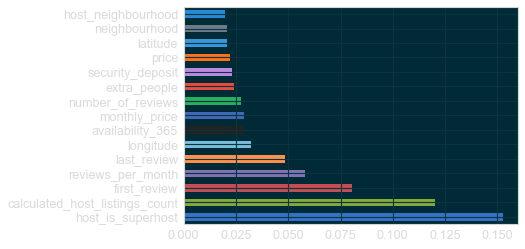

In [303]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False)[:15].plot('barh')

Clearly, the most important features have to do with the host being a superhost, and the amount of listings the host have. The features related to the reviews are not very informing. The other very important features have to do with the location, availability and price. Nothing unexpected there.

Let's see how the amount of listings that the host has affects the ratings

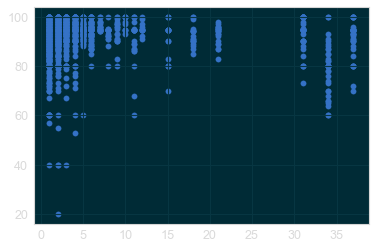

In [339]:
xy = pd.concat(
    [X.calculated_host_listings_count, y], axis=1).sort_values(
    by='calculated_host_listings_count')
plt.scatter(xy.calculated_host_listings_count, xy.review_scores_rating)

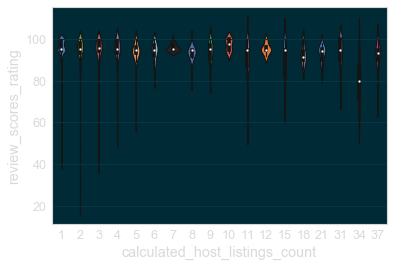

In [341]:
sns.violinplot(xy.calculated_host_listings_count, xy.review_scores_rating)

a = 7.0528912549799925, b = -5.90561632120227


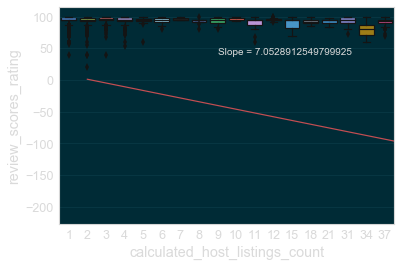

In [360]:
sns.boxplot(xy.calculated_host_listings_count, xy.review_scores_rating)
show_polyfit(xy.calculated_host_listings_count, xy.review_scores_rating)

In [343]:
xy.corr().iloc[0,1]

-0.20195436686006232

In [381]:
def show_polyfit(x, y, pos=(8, 40)):
    a, b = np.polyfit(x, y, deg=1)
    xx = np.linspace(x.min(), x.max(), 100)
    print('a = {}, b = {}'.format(a, b))
    plt.plot(xx, a*xx + b, 'r')
    plt.text(pos[0], pos[1], 'Slope = {}'.format(a))

a = 2.661479069058597, b = 25.867722968381894


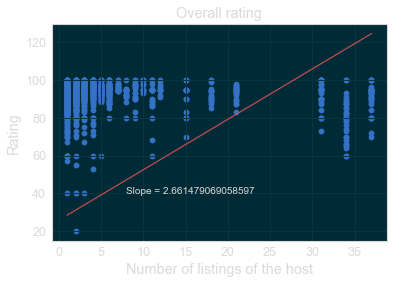

In [382]:
plt.scatter(xy.calculated_host_listings_count, xy.review_scores_rating)
plt.xlabel('Number of listings of the host')
plt.ylabel('Rating')
plt.title('Overall rating')
show_polyfit(xy.calculated_host_listings_count, xy.review_scores_rating)

In [392]:
x = xy.iloc[:,0].values
A = np.vstack([x, np.ones(len(x))]).T
y = xy.iloc[:,0].values
np.linalg.lstsq(A, y)

/Users/antelinvestigacionydesarrollo/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


(array([-0.05589808,  0.01678145]),
 array([165683.94085627]),
 2,
 array([103.82210888,   0.84014642]))

array([[ 1],
       [ 1],
       [ 1],
       ...,
       [37],
       [37],
       [37]])